# CMS classification and cell type annotation with CellTypist

The two relevant available models are from colorectal cancer and intestinal tract (not cancer). Of course, the cancer one is much more relevant to our data, but we can try both just to see what our cells are classified as when non-tumor intestinal cell type classification is forced upon them. It might indicate which cell types they are at least closest to, but the results may also be not interpretable at all.

The two datasets:

| Name | Details | No. cell types | Publish date | Paper |
| --- | --- | --- | --- | --- |
| Colorectal cancer | 1. cell types of colon tissues from patients with colorectal cancer | 36 | 2024-04-26 | https://doi.org/10.1038/s41588-020-0636-z |
| Intestinal tract | 2. intestinal cells from fetal, pediatric (healthy and Crohn's disease) and adult human gut | 134 | 2021-12-17 | https://doi.org/10.1038/s41586-021-03852-1 |

- [Paper](https://pmc.ncbi.nlm.nih.gov/articles/PMC7612735/)
- [Github](https://github.com/Teichlab/celltypist)
- [Website](https://www.celltypist.org/)
- [Workflow that I followed](https://www.sc-best-practices.org/cellular_structure/annotation.html)

>What is CellTypist?
>CellTypist is an automated cell type annotation tool for scRNA-seq datasets on the basis of logistic regression classifiers optimised by the stochastic gradient descent algorithm. Through CellTypist, cell type labels can be transferred from the built-in models (with a current focus on immune cell types) or any user-trained models to the query data.
>
>How are CellTypist models trained?
>All models are built on the logistic regression framework. Traditional logistic regression will be used in most cases. SGD learning can be optionally implemented depending on the size of the training dataset. For example, when the training dataset contains a huge number of cells, the data can be modelled with SGD logistic regression using mini-batch training. Briefly, in each epoch cells are shuffled and binned into equal-sized mini-batches (1,000 cells per batch), and later are sequentially trained by 100 such batches randomly sampled out of all batches. This process is repeated for 10~30 epochs. Users can also generate their own models through one of these approaches.
>
>How are cell type labels assigned to query datasets?
>For each shared gene between the model and query data, CellTypist will standardise it according to the parameters recorded in the model. The decision scores of query cells are defined as the linear combination of the scaled gene expression and the model coefficients associated with a given cell type, and the cell type with the maximal decision score is selected as the predicted identity.
>
>How does the majority voting add to the prediction?
>Prediction results are refined by a majority voting approach based on the idea that transcriptionally similar cells are more likely to form a (sub)cluster regardless of their individual prediction outcomes. The query data will be over-clustered (by Leiden clustering with a canonical Scanpy pipeline) and each resulting subcluster is assigned the identity supported by the dominant cell type predicted. Through this, distinguishable small subclusters will be assigned distinct labels, and homogenous subclusters will be assigned the same labels and iteratively converge to a bigger cluster.

## [General remarks on automated annotation](https://www.sc-best-practices.org/cellular_structure/annotation.html#general-remarks)

>The quality of automatically generated annotations can vary. More specifically, the quality of the annotations depends on:
>
>The type of classifier chosen: Previous benchmark studies have shown that different types of classifiers often perform comparably, with neural network-based methods generally not outperforming general-purpose models such as support vector machines or linear regression models[Abdelaal et al., 2019], [Pasquini et al., 2021], [Huang and Zhang, 2021].
>
>1. The quality of the data that the classifier was trained on. If the training data was not well annotated or annotated at low resolution, the classifier will do the same. Similarly, if the training data and/or its annotation was noisy, the classifier might not perform well.
>
>2. The similarity of your own data to the data that the classifier was trained on. For example, if the classifier was trained on a drop-seq single cell dataset and your data is 10X single nucleus rather than single cell drop-seq, this might worsen the quality of the annotation. Classifiers trained on cross-dataset atlases including a diversity of datasets might give more robust and better quality annotations than classifiers trained on a single dataset. An example is the CellTypist (an automated annotation method that will be discussed more extensively below) classifier trained on the Human Lung Cell Atlas [Sikkema et al., 2023] which includes 14 different lung datasets. This model is likely to perform better on new lung data than a model that was trained on a single lung dataset.
>
>3. The aforementioned points highlight possible disadvantages of using classifiers, depending on the training data and model type. Nonetheless, there are several important advantages of using pre-trained classifiers to annotate your data. First, it is a fast and easy way to annotate your data. The annotation does not require the downloading nor preprocessing of the training data and sometimes merely involves the upload of your data to an online webpage. Second, these methods don’t rely on a partitioning of your data into clusters, as the manual annotation does. Third, pre-trained classifiers enable you to directly leverage the knowledge and information from previous studies, such as a high quality annotation. And finally, using such classifiers can help with harmonizing cell-type definitions across a field, thereby clearing the path towards a field-wide consensus on these definitions.
>
>Finally, as these classifiers are often less transparent than e.g. manual marker-based annotation, a good uncertainty measure quantifying annotation uncertainty will improve the quality and usability of the method. We will discuss this more extensively further down.

### Marker gene-based classifiers

>One class of automated cell type annotation methods relies on a predefined set of marker genes. Cells are classified into cell types based on their expression levels of these marker genes. Examples of such methods are Garnett [Pliner et al., 2019] and CellAssign [Zhang et al., 2019]. The more robust and generalizable the set of marker genes these models are based on, the better the model will perform. However, like with other models they are likely to be affected by batch effect-related differences between the data the model was trained on and the data that needs to be labeled. One of the advantages of these methods compared to models based on larger gene sets (see below) is that they are more transparent: we know on the basis of which genes the classification is done.
We will not show an example of marker-based classifiers in this notebook, but encourage you to explore these yourself if you are interested.

### Classifiers based on a wider set of genes

>It is worth noting that the methods discussed so far use only a small subset of the genes detected in the data: often a set of only 1 to ~10 marker genes per cell type is used. An alternative approach is to use a classifier that takes as input a larger set of genes (several thousands or more), thereby making more use of the breadth of scRNA-seq data. Such classifiers are trained on previously annotated datasets or atlases. Examples of these are CellTypist [Conde et al., 2022] (see also https://www.celltypist.org, where data can be uploaded to a portal to get automated cell annotations) and Clustifyr [Fu et al., 2020].

Let’s try out CellTypist on our data.

In [ ]:
import urllib.request
from pathlib import Path

import celltypist
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
# import scarches as sca
import seaborn as sns
from celltypist import models
from scipy.sparse import csr_matrix

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

from numba.core.errors import NumbaDeprecationWarning
warnings.simplefilter("ignore", category=NumbaDeprecationWarning)
warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)

sc.settings.verbosity = 0

In [4]:
# this cell is tagged 'parameters' to use papermill
input_file = "/data/cephfs-1/home/users/cemo10_c/work/scRNA/scRNA_preprocessing_pipeline/results/chosen_branch/adata_subset_stripped.h5ad"
clusters_file = "/data/cephfs-1/home/users/cemo10_c/work/scRNA/scRNA_preprocessing_pipeline/results/chosen_branch/clusters_scmiko_subset_chosen_res.csv"
output_csv = "/data/cephfs-1/home/users/cemo10_c/work/scRNA/scRNA_preprocessing_pipeline/results/chosen_branch/celltypist_cms_types.csv"

In [5]:
adata = sc.read(input_file)
adata

AnnData object with n_obs × n_vars = 22799 × 11449
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'soupx_contamination', 'scDblFinder_score', 'scDblFinder_class', 'size_factors', 'leiden', 'leiden_res0_25', 'leiden_res0_5', 'leiden_res1', 'leiden_1', 'leiden_2', 'CMS1_score', 'CMS2_score', 'CMS3_score', 'CMS4_score', 'CMS', 'celltypist_cell_label_gut', 'celltypist_conf_score_gut', 'celltypist_cell_label_crc', 'celltypist_conf_score_crc', 'treatment', 'week', 'sample', 'S_score', 'G2M_score', 'phase', 'cell_cycle_diff'
    var: 'mean', 'std', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'diffmap_evals', 'hvg', 'neighbors', 'pca', 'phase_colors', 'sample_colors', 'treatment_c

 Based on the CellTypist tutorial (https://www.celltypist.org/tutorials) we know we need to prepare our data so that counts are normalized to 10,000 counts per cell, then log1p-transformed:

In [6]:
adata.X = adata.layers["counts"]  # set adata.X to raw counts
sc.pp.normalize_total(adata, target_sum=10**4)  # normalize to 10,000 counts per cell
sc.pp.log1p(adata)  # log-transform
# make .X dense instead of sparse, for compatibility with celltypist:
adata.X = adata.X.toarray()

In [7]:
model_crc = models.Model.load(model="Human_Colorectal_Cancer.pkl")
model_gut = models.Model.load(model="Cells_Intestinal_Tract.pkl")

Which cell types are in the colorectal cancer model?

In [8]:
model_crc.cell_types

array(['CD19+CD20+ B', 'CD4+ T cells', 'CD8+ T cells', 'CMS1', 'CMS2',
       'CMS3', 'CMS4', 'Enteric glial cells', 'Goblet cells',
       'IgA+ Plasma', 'IgG+ Plasma', 'Intermediate', 'Lymphatic ECs',
       'Mast cells', 'Mature Enterocytes type 1',
       'Mature Enterocytes type 2', 'Myofibroblasts', 'NK cells',
       'Pericytes', 'Pro-inflammatory', 'Proliferating',
       'Proliferative ECs', 'Regulatory T cells', 'SPP1+',
       'Smooth muscle cells', 'Stalk-like ECs', 'Stem-like/TA',
       'Stromal 1', 'Stromal 2', 'Stromal 3', 'T follicular helper cells',
       'T helper 17 cells', 'Tip-like ECs', 'Unknown', 'cDC',
       'gamma delta T cells'], dtype=object)

In [9]:
predictions_gut_adata = celltypist.annotate(adata, model=model_gut, majority_voting=True).to_adata()
adata.obs["all_celltypist_cell_label_gut"] = predictions_gut_adata.obs.loc[
    adata.obs.index, "majority_voting"
]
adata.obs["all_celltypist_conf_score_gut"] = predictions_gut_adata.obs.loc[
    adata.obs.index, "conf_score"
]
del predictions_gut_adata

🔬 Input data has 22799 cells and 11449 genes


🔗 Matching reference genes in the model
🧬 1250 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 15
🗳️ Majority voting the predictions
✅ Majority voting done!


In [10]:
predictions_crc_adata = celltypist.annotate(adata, model=model_crc, majority_voting=True).to_adata()
adata.obs["all_celltypist_cell_label_crc"] = predictions_crc_adata.obs.loc[
    adata.obs.index, "majority_voting"
]
adata.obs["all_celltypist_conf_score_crc"] = predictions_crc_adata.obs.loc[
    adata.obs.index, "conf_score"
]
del predictions_crc_adata

🔬 Input data has 22799 cells and 11449 genes
🔗 Matching reference genes in the model
🧬 2554 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 15
🗳️ Majority voting the predictions
✅ Majority voting done!


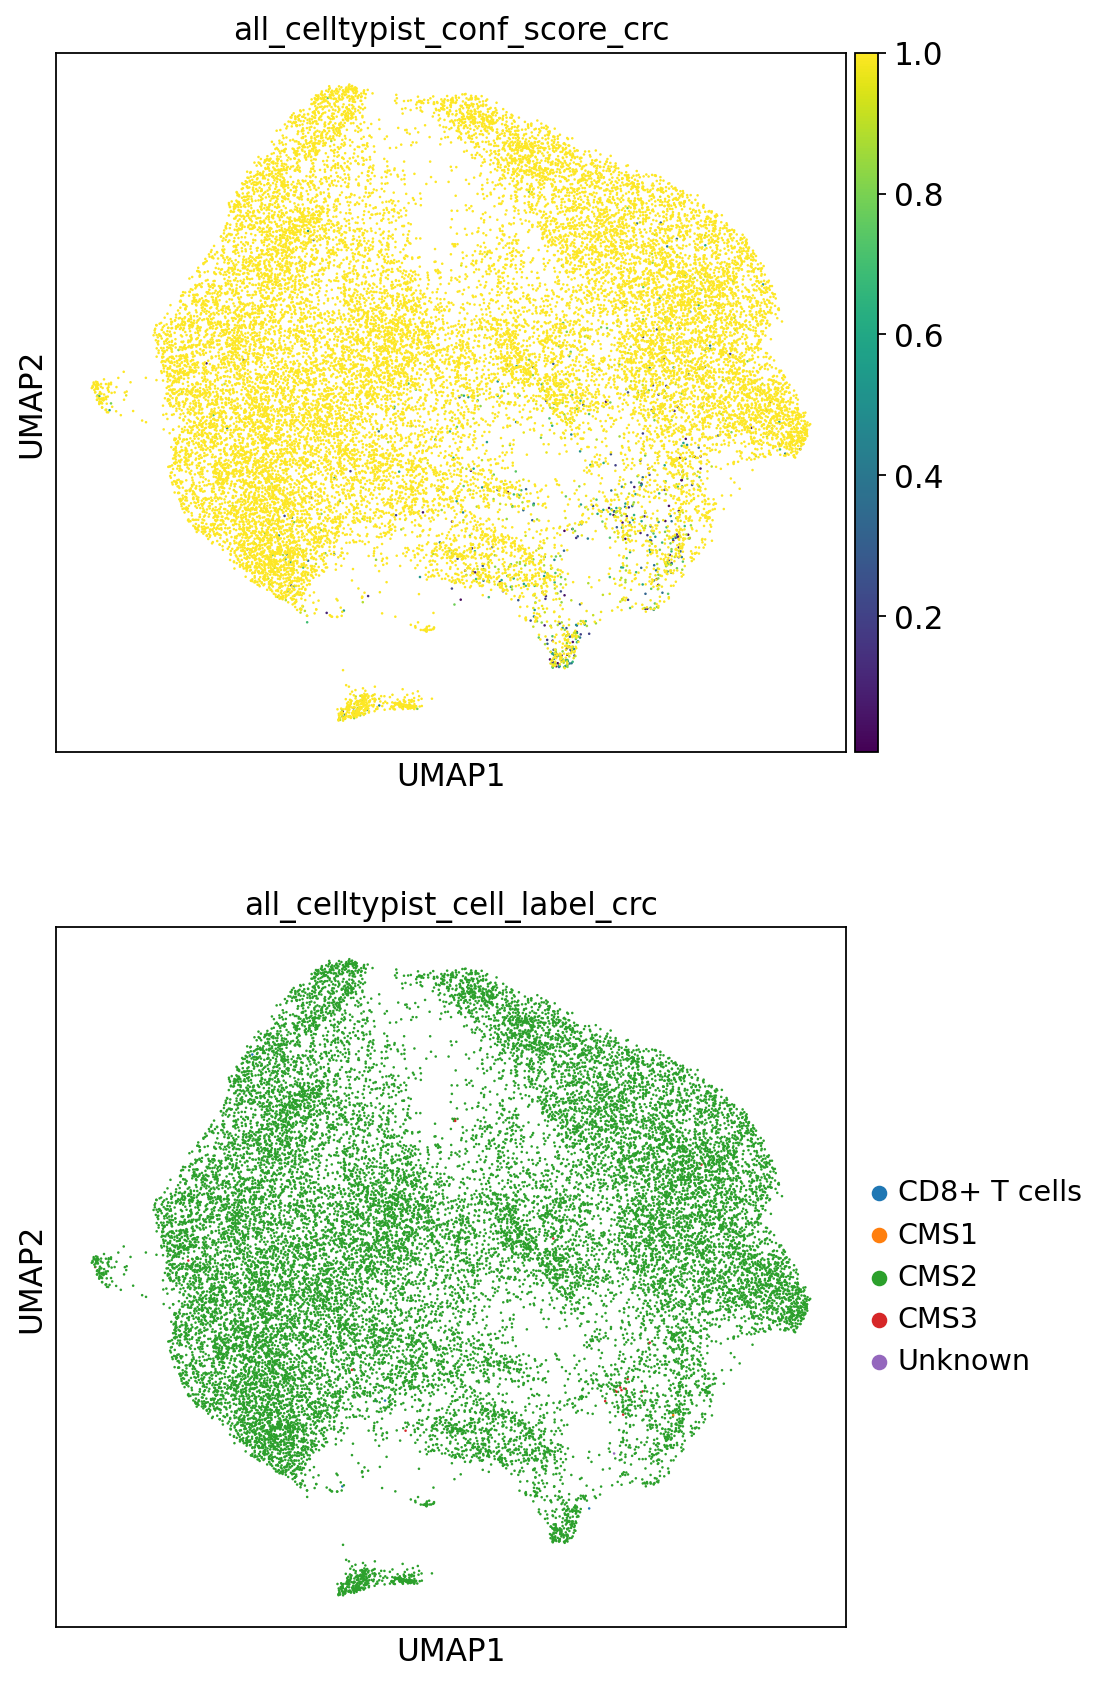

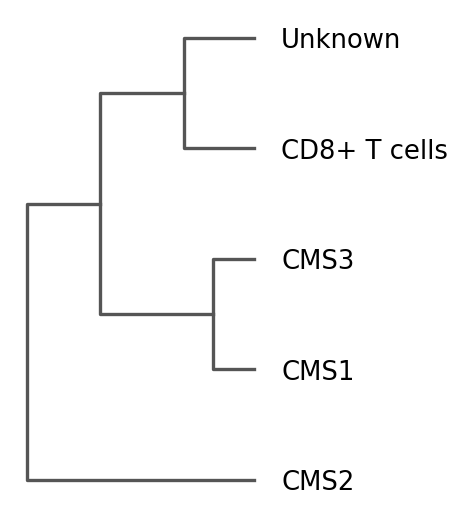

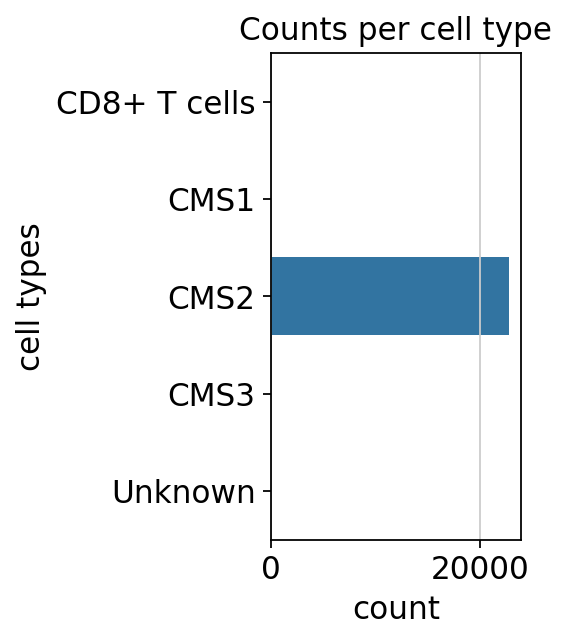

In [ ]:
sc.settings.set_figure_params(dpi=80, figsize=(6, 6))
sc.pl.umap(adata, color=["all_celltypist_conf_score_crc", "all_celltypist_cell_label_crc"], ncols=1)

if len(adata.obs["all_celltypist_cell_label_crc"].unique()) > 1:
    sc.settings.set_figure_params(dpi=80, figsize=(2,4))
    sc.pl.dendrogram(adata, groupby="all_celltypist_cell_label_crc", orientation="left")
    ax = sns.countplot(y="all_celltypist_cell_label_crc", data=adata.obs)
    ax.set_title('Counts per cell type')
    ax.set_ylabel('cell types')

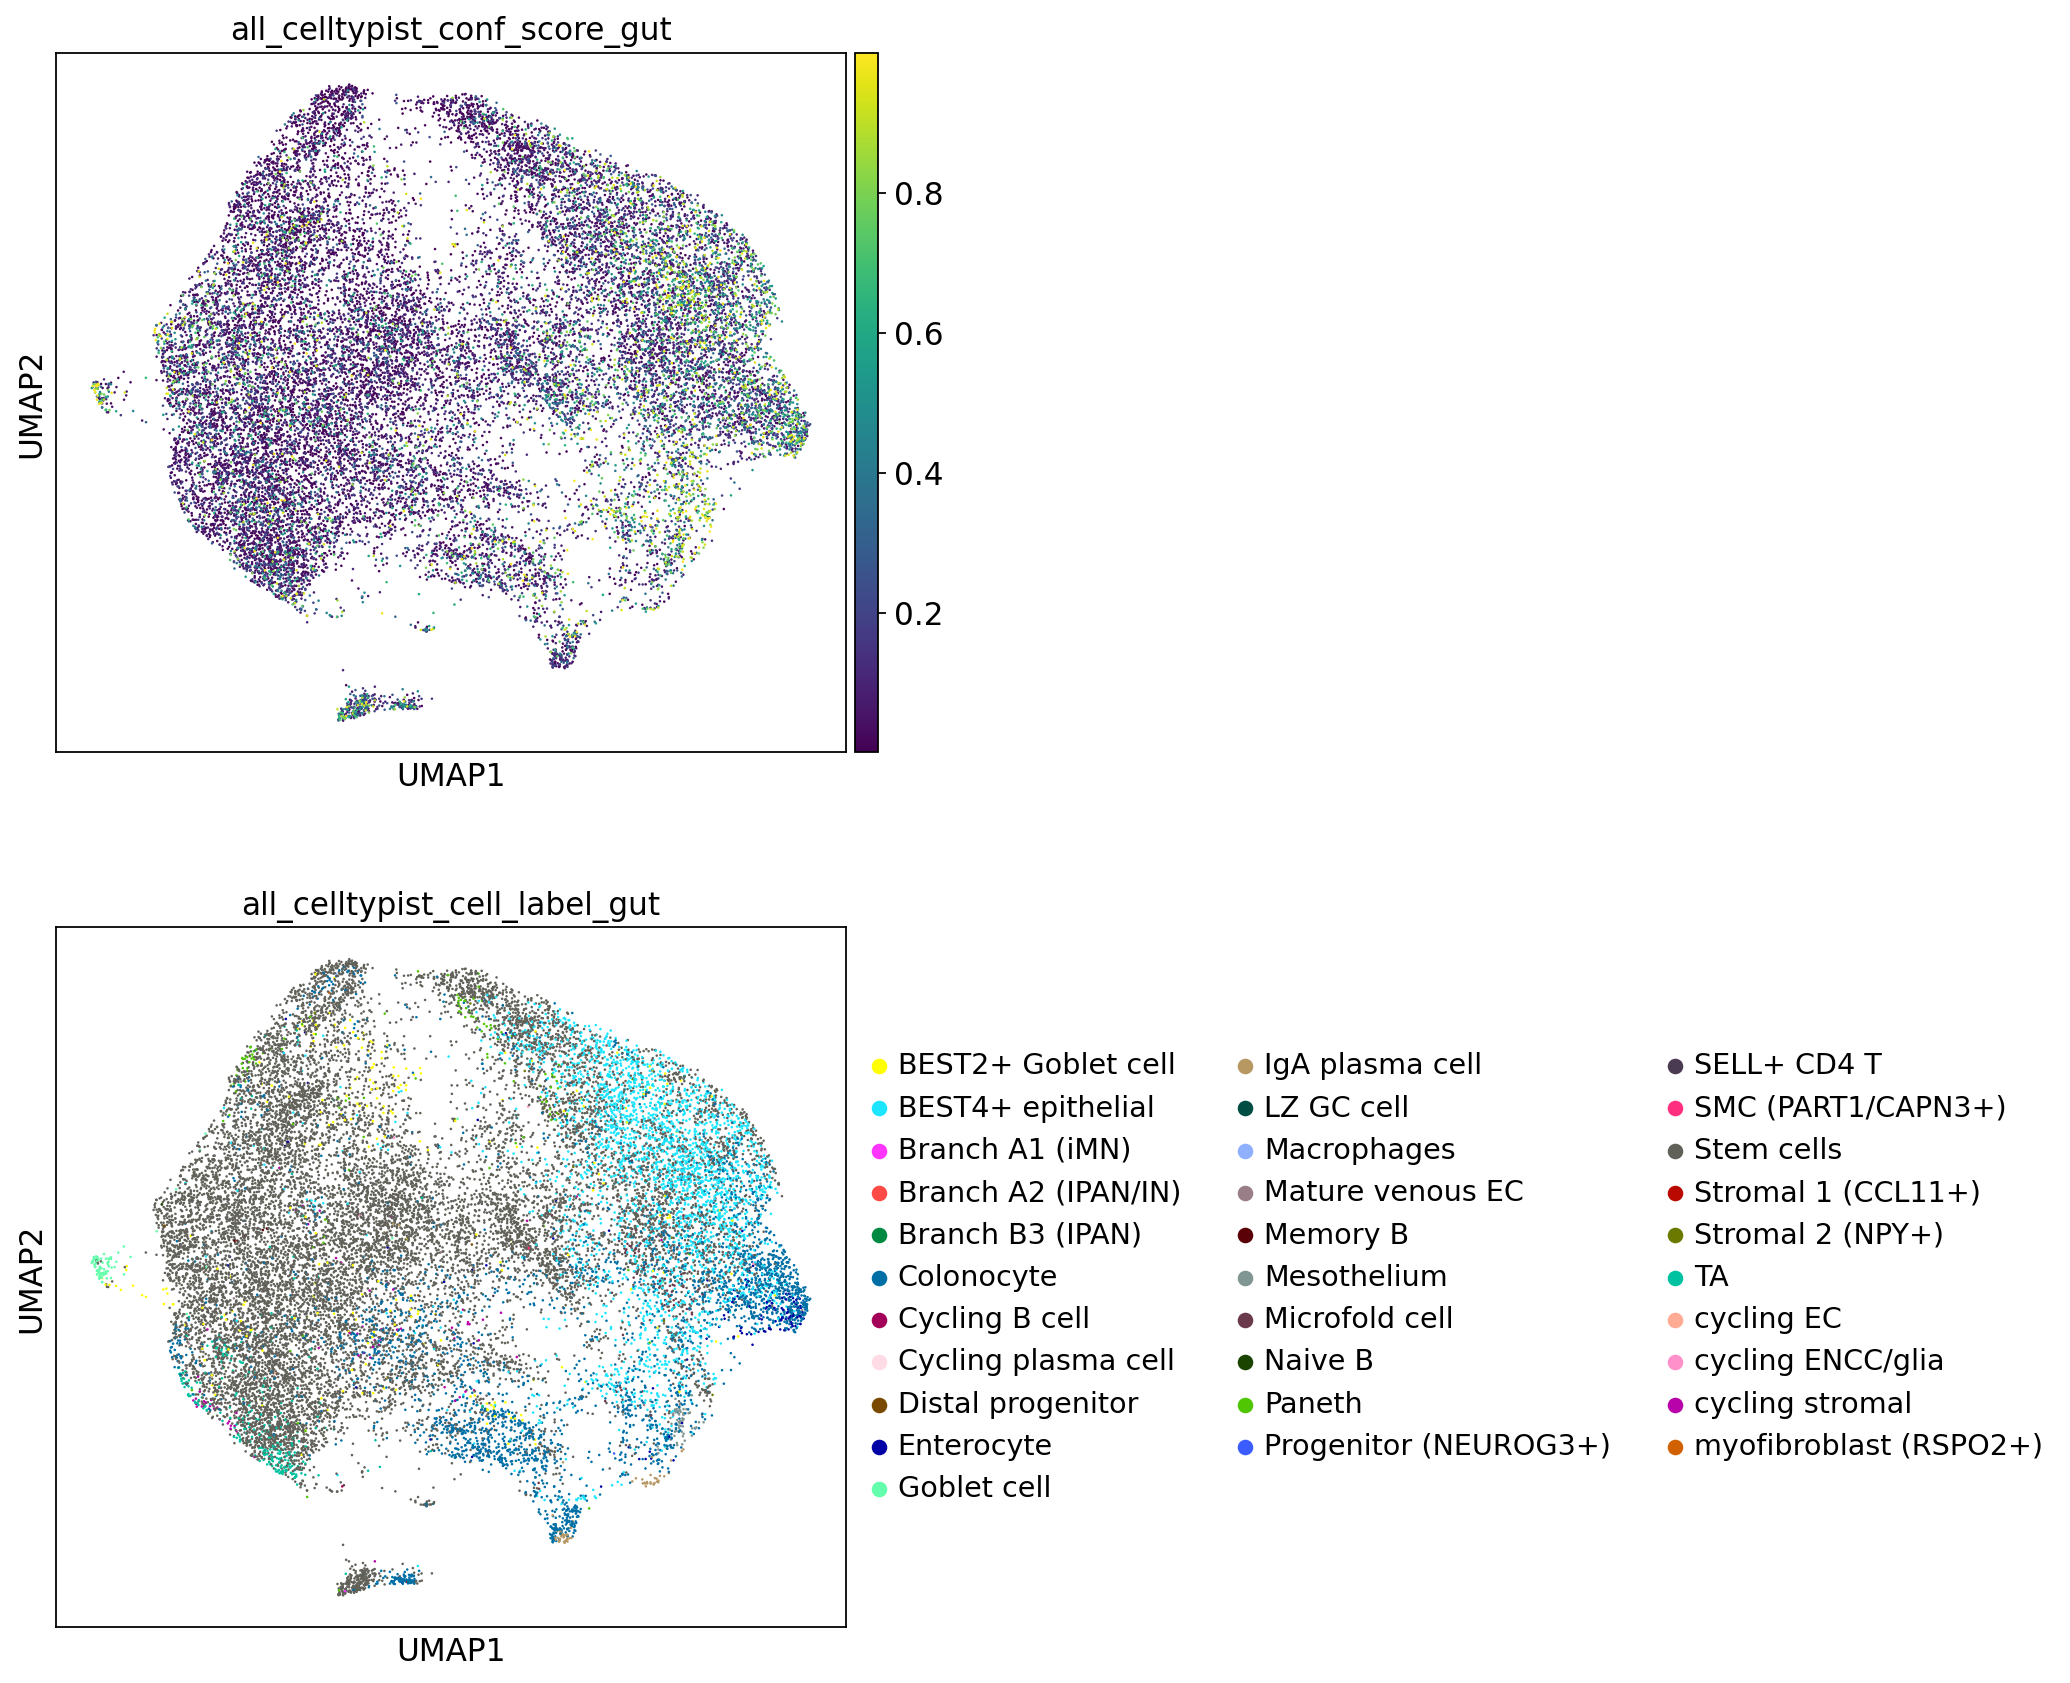

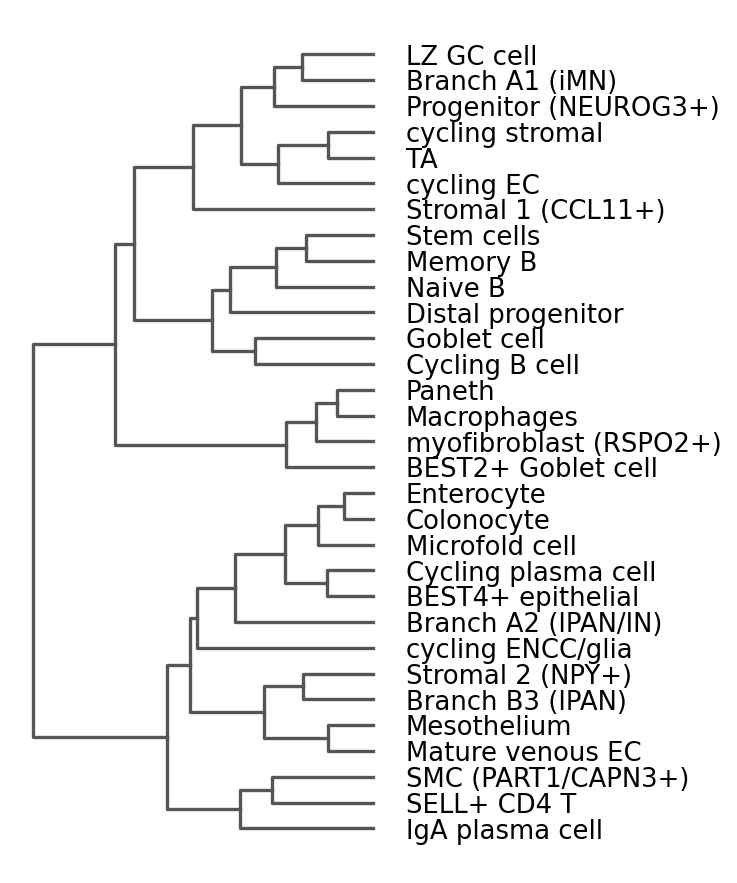

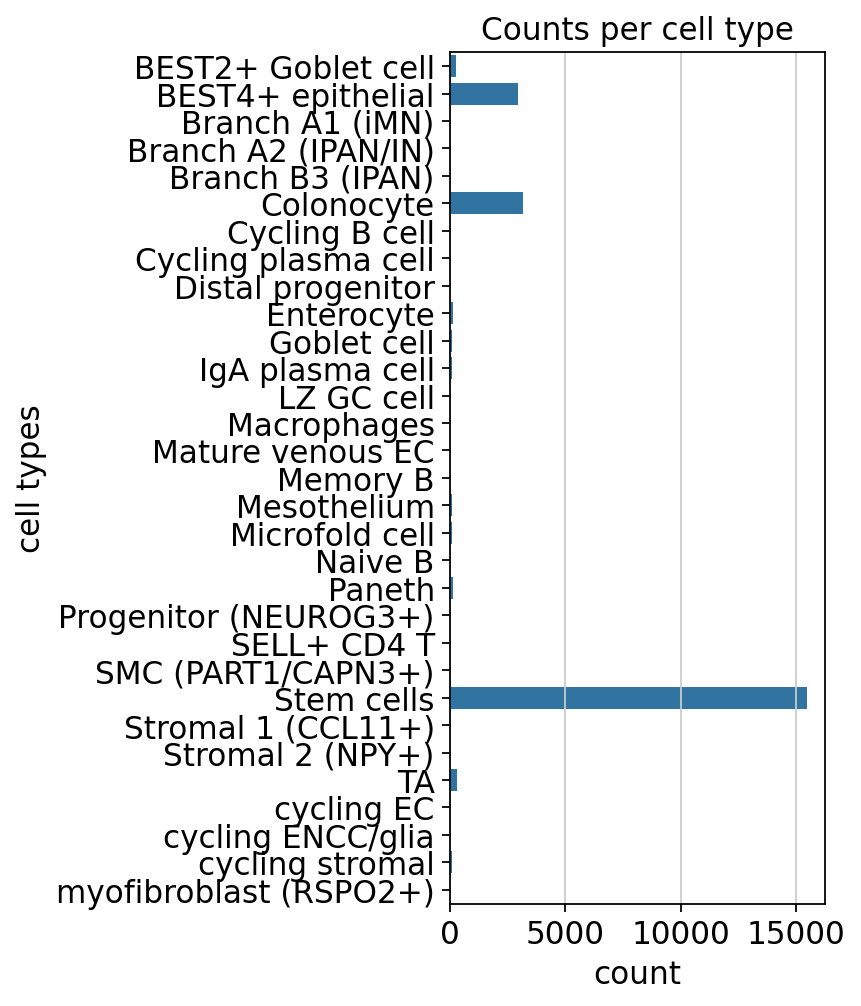

In [ ]:
sc.settings.set_figure_params(dpi=80, facecolor="white", figsize=(6, 6))
sc.pl.umap(adata, color=["all_celltypist_conf_score_gut", "all_celltypist_cell_label_gut"], ncols=1)

if len(adata.obs["all_celltypist_cell_label_gut"].unique()) > 1:
    sc.settings.set_figure_params(dpi=80, facecolor="white", figsize=(3, 8))
    sc.pl.dendrogram(adata, groupby="all_celltypist_cell_label_gut", orientation="left")
    ax = sns.countplot(y="all_celltypist_cell_label_gut", data=adata.obs)
    ax.set_title('Counts per cell type')
    ax.set_ylabel('cell types')


In [13]:
# save to csv
adata.obs[["all_celltypist_cell_label_gut", "all_celltypist_cell_label_crc"]].to_csv(output_csv)